In [5]:
#!pip install pystan
#!pip install fbprophet

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore")

#import fbprophet

In [45]:
# Aggregating data based on month
sales_ts = pd.read_csv('sample.csv', index_col=[0], parse_dates=True, squeeze=True)
df = pd.DataFrame(sales_ts.groupby(['Date','region']).agg({'product_1': 'sum', 'product_2': 'sum', 'product_3': 'sum'}))
new_sale_data = df.reset_index()

In [46]:
new_sale_data.set_index = new_sale_data['Date']

In [47]:
us_product1_sale = pd.DataFrame(new_sale_data[new_sale_data['region']=='US'], columns=['Date','product_1'])
us_product1_sale.index = us_product1_sale['Date']
us_product1_sale = us_product1_sale.drop(columns=['Date'])
us_product1_sale_ts = us_product1_sale.squeeze()

<AxesSubplot:xlabel='Date'>

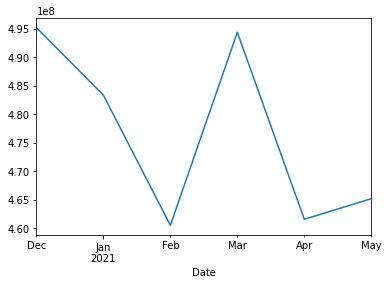

In [48]:
us_product1_sale_ts.plot()

In [49]:
us_product1_sale_ts.describe()

count    6.000000e+00
mean     4.767117e+08
std      1.627182e+07
min      4.605151e+08
25%      4.624821e+08
50%      4.742760e+08
75%      4.916414e+08
max      4.952228e+08
Name: product_1, dtype: float64

## Creating Baseline Model

### shift method

In [50]:
us_product1_sale_ts_base = pd.concat([us_product1_sale_ts, us_product1_sale_ts.shift(1)], axis=1)

In [51]:
us_product1_sale_ts_base

,product_1,product_1
Date,,
2020-12-01,495222756,NaN
2021-01-01,483361528,495222756.0
2021-02-01,460515134,483361528.0
2021-03-01,494401330,460515134.0
2021-04-01,461579299,494401330.0
2021-05-01,465190433,461579299.0


In [52]:
us_product1_sale_ts_base.dropna(inplace=True)

In [53]:
us_product1_sale_ts_base.columns = ['Actual Sales', 'Forcast Sales']

In [54]:
us_product1_sale_ts_error =mean_squared_error(us_product1_sale_ts_base['Actual Sales'], us_product1_sale_ts_base['Forcast Sales'])

In [55]:
us_product1_sale_ts_error

580249347110510.6

In [56]:
np.sqrt(us_product1_sale_ts_error)

24088365.38892813

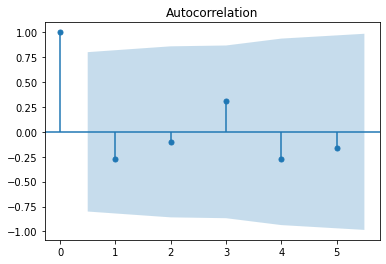

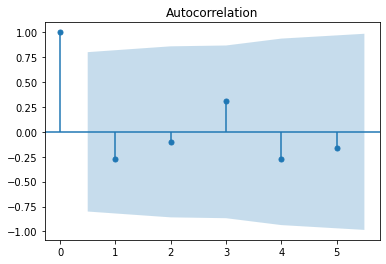

In [57]:
plot_acf(us_product1_sale_ts)

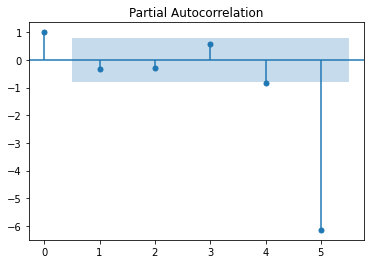

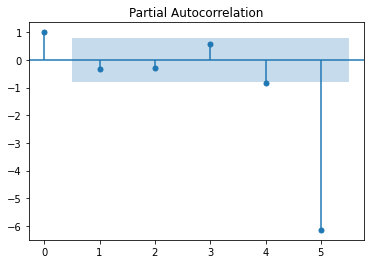

In [58]:
plot_pacf(us_product1_sale_ts)

## ARIMA Model

In [59]:
us_product1_sale_ts_train = us_product1_sale_ts[0:4]
us_product1_sale_ts_test = us_product1_sale_ts[3:6]

In [60]:
us_product1_sale_ts_train

Date
2020-12-01    495222756
2021-01-01    483361528
2021-02-01    460515134
2021-03-01    494401330
Name: product_1, dtype: int64

In [61]:
us_product1_sale_ts_test

Date
2021-03-01    494401330
2021-04-01    461579299
2021-05-01    465190433
Name: product_1, dtype: int64

## Hyperparameter tuning

In [62]:
p_values = range(0,5)
d_values = range(0,3)
q_values = range(0,5)

In [63]:
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            train, test = us_product1_sale_ts[0:4], us_product1_sale_ts[3:6]
            predictions = list()
            for i in range(len(test)):
                try:
                    model = ARIMA(train, order)
                    model_fit = model.fit(disp=0)
                    pred_y = model_fit.forecast()[0]
                    predictions.append(pred_y)
                    error = mean_squared_error(test, predictions)
                    print('ARIMA%s - RMSE = %.2f'% (order,np.sqrt(error)))
                    print(predictions)
                except:
                    continue

ARIMA(0, 0, 1) - RMSE = 15556907.86
[array([4.78828739e+08]), array([4.78828739e+08]), array([4.78828739e+08])]
ARIMA(0, 1, 1) - RMSE = 15580047.48
[array([4.78898825e+08]), array([4.78898825e+08]), array([4.78898825e+08])]
ARIMA(1, 0, 0) - RMSE = 14789374.40
[array([4.72059428e+08]), array([4.72059428e+08]), array([4.72059428e+08])]
ARIMA(1, 1, 0) - RMSE = 15479538.98
[array([4.78587872e+08]), array([4.78587872e+08]), array([4.78587872e+08])]


In [64]:
us_product1_sale_ARIMA_model = ARIMA(us_product1_sale_ts_train, order=(1,0,0))

In [65]:
us_product1_sale_ARIMA_model_fit = us_product1_sale_ARIMA_model.fit()

In [66]:
us_product1_sale_ARIMA_model_forecast = us_product1_sale_ARIMA_model_fit.forecast(steps=3)[0]

In [67]:
np.sqrt(mean_squared_error(us_product1_sale_ts_test, us_product1_sale_ARIMA_model_forecast ))

19354285.36624934

## Observation
* Arima perform better than BaseLine model

In [32]:
future_months = ['2021-03-01','2021-04-01', '2021-05-01', '2021-06-01','2021-07-01', '2021-08-01', '2021-09-01']

### loop for regions and products

Europe - product_1
Europe - product_1 RMSE = 23567826.22
ARIMA(0, 1, 1) - RMSE = 28293844.21
[array([1.91101099e+08]), array([1.91101099e+08]), array([1.91101099e+08])]
ARIMA(1, 0, 0) - RMSE = 37114655.61
[array([1.99943791e+08]), array([1.99943791e+08]), array([1.99943791e+08])]
ARIMA(1, 1, 0) - RMSE = 4319153.20
inside
best order inside (1, 1, 0)
[array([1.66568584e+08]), array([1.66568584e+08]), array([1.66568584e+08])]
4847794.216306698
Europe - product_2
Europe - product_2 RMSE = 1156567.30
ARIMA(0, 0, 1) - RMSE = 1426426.32
[array([41946838.45077426]), array([41946838.45077426]), array([41946838.45077426])]
ARIMA(0, 1, 1) - RMSE = 1848820.24
[array([42398959.66468097]), array([42398959.66468097]), array([42398959.66468097])]
ARIMA(1, 0, 0) - RMSE = 1281013.64
[array([41785941.15861442]), array([41785941.15861442]), array([41785941.15861442])]
ARIMA(1, 1, 0) - RMSE = 1966637.40
[array([42522603.28466778]), array([42522603.28466778]), array([42522603.28466778])]
ARIMA(2, 0, 0) - RM

2466322.0374877993
US - product_3
US - product_3 RMSE = 358966.83
ARIMA(0, 0, 1) - RMSE = 713761.93
[array([6741072.55187677]), array([6741072.55187677]), array([6741072.55187677])]
ARIMA(0, 1, 1) - RMSE = 535287.45
[array([6922519.29781451]), array([6922519.29781451]), array([6922519.29781451])]
ARIMA(1, 0, 0) - RMSE = 791309.49
[array([6662658.9863697]), array([6662658.9863697]), array([6662658.9863697])]
ARIMA(1, 1, 0) - RMSE = 577039.31
[array([8012277.88221839]), array([8012277.88221839]), array([8012277.88221839])]
595004.2919242388
PARTNER - product_1
PARTNER - product_1 RMSE = 1450590.97
ARIMA(0, 0, 1) - RMSE = 1891782.61
[array([1892983.05672602]), array([1892983.05672602])]
ARIMA(1, 0, 0) - RMSE = 2386784.60
[array([1283528.81754114]), array([1283528.81754114])]
ARIMA(1, 1, 0) - RMSE = 1244455.63
inside
best order inside (1, 1, 0)
[array([3476704.51419555]), array([3476704.51419555])]
1011268.9778192379
PARTNER - product_2
PARTNER - product_2 RMSE = 59151.91
ARIMA(0, 0, 1) - 

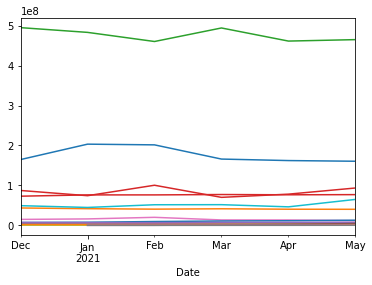

In [68]:
prediction_list = list()

for region in new_sale_data['region'].unique():
    for product in ['product_1', 'product_2', 'product_3']:
        sale = pd.DataFrame(new_sale_data[new_sale_data['region']==region], columns=['Date',product])
        sale.index = sale['Date']
        sale = sale.drop(columns=['Date'])
        sale_ts = sale.squeeze()

        print ('%s - %s'% (region,product))

        sale_ts.plot()

        #base model
        sale_ts_base = pd.concat([sale_ts, sale_ts.shift(1)], axis=1)
        sale_ts_base.dropna(inplace=True)
        sale_ts_base.columns = ['Actual Sales', 'Forcast Sales']

        sale_ts_error =mean_squared_error(sale_ts_base['Actual Sales'], sale_ts_base['Forcast Sales'])
        print('%s - %s RMSE = %.2f'% (region, product , np.sqrt(sale_ts_error)))


        # ARIMA model
        sale_ts_train = sale_ts[0:4]
        sale_ts_test = sale_ts[3:6]

        #hyper parameter tuning

        p_values = range(0,5)
        d_values = range(0,3)
        q_values = range(0,5)

        rmse_list = list()
        min_rmse = np.sqrt(sale_ts_error)
        best_order = (0,0,1)
        for p in p_values:
            for d in d_values:
                for q in q_values:
                    order = (p,d,q)
                    train, test = sale_ts[0:4], sale_ts[3:6]
                    predictions = list()
                    for i in range(len(test)):
                        try:
                            model = ARIMA(train, order)
                            model_fit = model.fit(disp=0)
                            pred_y = model_fit.forecast()[0]
                            predictions.append(pred_y)
                            error = mean_squared_error(test, predictions)
                            print('ARIMA%s - RMSE = %.2f'% (order,np.sqrt(error)))
                            rmse_list.append({'order': order, 'rmse': np.sqrt(error)})
                            if (min_rmse > np.sqrt(error)):
                                print ('inside')
                                min_rmse = np.sqrt(error)
                                best_order = order
                                print ('best order inside %s'%  (str(best_order)))
                            print(predictions)
                        except:
                            continue

        sale_ARIMA_model = ARIMA(sale_ts_train, order=best_order)
        sale_ARIMA_model_fit = sale_ARIMA_model.fit()
        sale_ARIMA_model_forecast = sale_ARIMA_model_fit.forecast(steps=len(sale_ts_test))[0]
        print( np.sqrt(mean_squared_error(sale_ts_test, sale_ARIMA_model_forecast )))
        prediction_list.append({'region': region, 
                                'product': product,
                                 'ARIMA_model': sale_ARIMA_model_fit})

In [36]:
prediction_list

[{'region': 'Europe',
  'product': 'product_1',
  'ARIMA_model': <statsmodels.tsa.arima_model.ARIMAResultsWrapper at 0x25092208048>},
 {'region': 'Europe',
  'product': 'product_2',
  'ARIMA_model': <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x250921edd48>},
 {'region': 'Europe',
  'product': 'product_3',
  'ARIMA_model': <statsmodels.tsa.arima_model.ARIMAResultsWrapper at 0x250922084c8>},
 {'region': 'ICON - LACAN',
  'product': 'product_1',
  'ARIMA_model': <statsmodels.tsa.arima_model.ARIMAResultsWrapper at 0x25092213ac8>},
 {'region': 'ICON - LACAN',
  'product': 'product_2',
  'ARIMA_model': <statsmodels.tsa.arima_model.ARIMAResultsWrapper at 0x250922192c8>},
 {'region': 'ICON - LACAN',
  'product': 'product_3',
  'ARIMA_model': <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x2509222dd88>},
 {'region': 'ICON - TMEA',
  'product': 'product_1',
  'ARIMA_model': <statsmodels.tsa.arima_model.ARIMAResultsWrapper at 0x2509222da48>},
 {'region': 'ICON - TMEA',
  'product': '

In [69]:
future_months = ['2021-03-01','2021-04-01', '2021-05-01', '2021-06-01','2021-07-01', '2021-08-01', '2021-09-01']

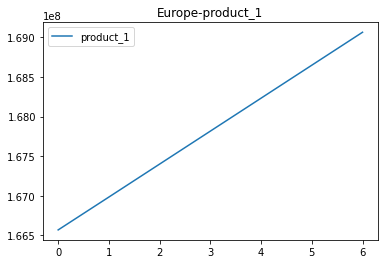

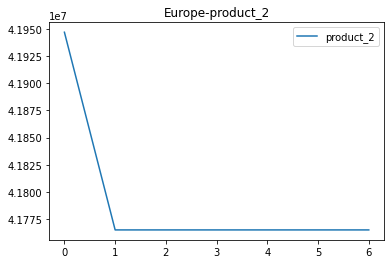

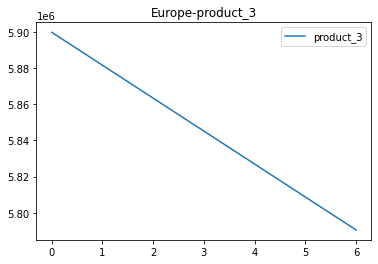

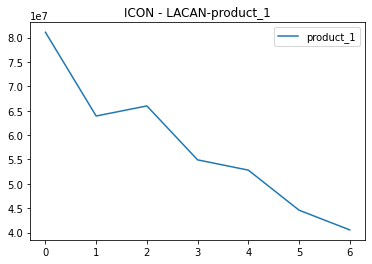

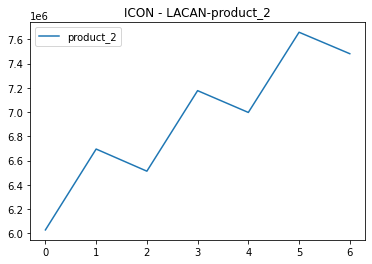

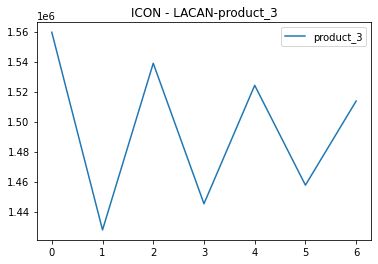

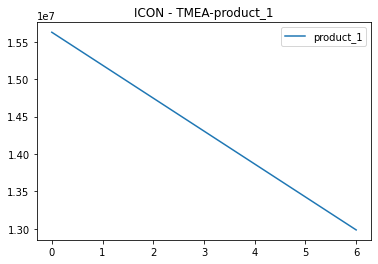

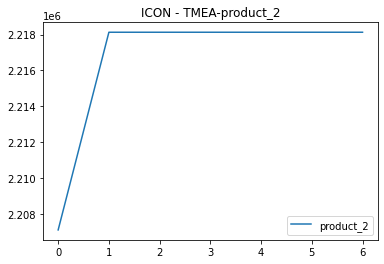

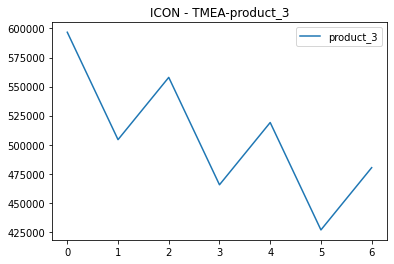

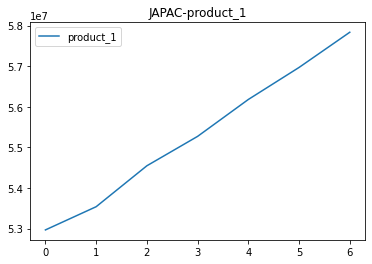

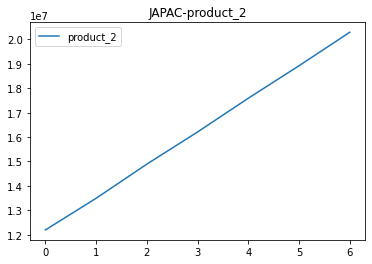

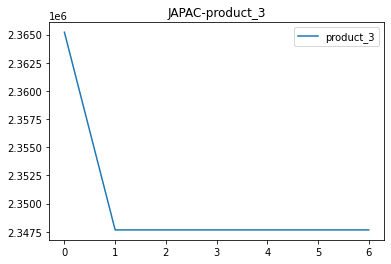

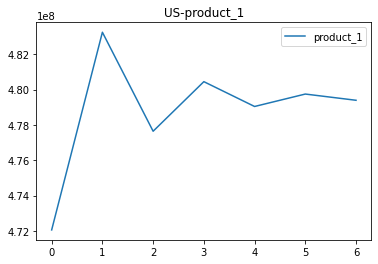

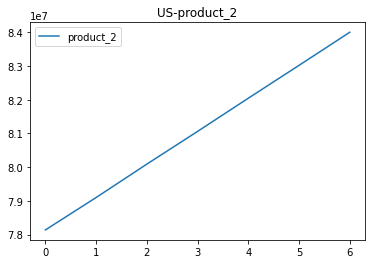

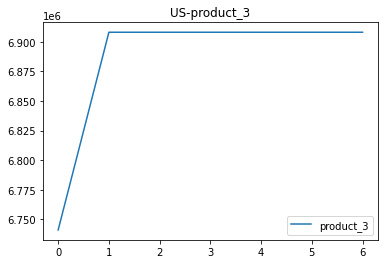

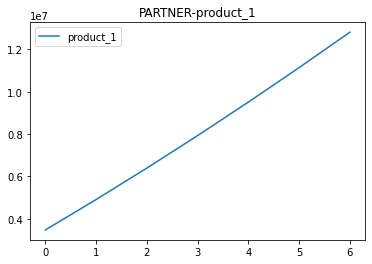

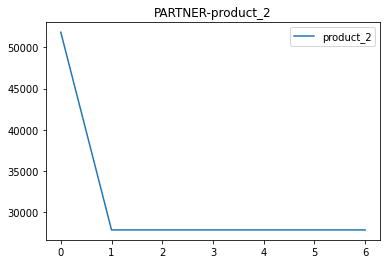

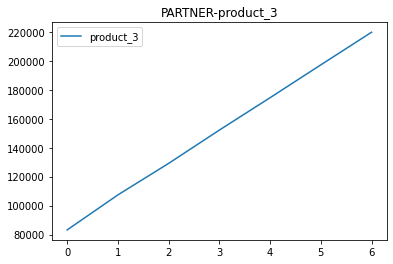

In [75]:
for prediction in prediction_list:
    forecast_for_next_4_months = prediction['ARIMA_model'].forecast(steps=7)[0]
    forecast = pd.DataFrame({'Date': future_months, prediction['product']: forecast_for_next_4_months})
    forecast.plot(title = prediction['region']+"-"+prediction['product'])